In [1]:
from IPython.display import Image
import itertools

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import autograd.numpy as np
from autograd import grad

%matplotlib inline

Let's define a function to perform [AdaM](https://arxiv.org/abs/1412.6980) updates...

In [2]:
# AdaM: Adaptive Moments Optimizer
## Params
### alpha0: base learning rate
### grad: current gradient
### adam_values: dictionary containing moment estimates

def get_AdaM_update(alpha_0, grad, adam_values, b1=.95, b2=.999, e=1e-8):
    adam_values['t'] += 1

    # update mean                                                                                                                                                                                                     
    adam_values['mean'] = b1 * adam_values['mean'] + (1-b1) * grad
    m_hat = adam_values['mean'] / (1-b1**adam_values['t'])

    # update variance                                                                                                                                                                                                 
    adam_values['var'] = b2 * adam_values['var'] + (1-b2) * grad**2
    v_hat = adam_values['var'] / (1-b2**adam_values['t'])

    return alpha_0 * m_hat/(np.sqrt(v_hat) + e)

## 0.  Overview

This notebook summarizes [Perturbative Black Box Variational Inference](https://arxiv.org/abs/1709.07433).  

## 1.  Simulated Posterior: Mixture Density

We are going to demonstrate all techniques on a simulated posterior.  As posteriors in the wild are often multimodal, we'll use a Gaussian mixture as our demonstration...

In [3]:
# Gaussian
def gaussPdf(x, params):
    # params: {'mu': mean, 'sigma': standard dev.}
    return (1./np.sqrt(2*np.pi*params['sigma']**2)) * np.exp((-.5/params['sigma']**2) * np.sum((x-params['mu'])**2))

# 2D Gaussian Mixture
def logGaussMixPDF(x, params):
    # params: {'pi': list of weights, 'mu': list of means, 'sigma': list of standard devs}
    return np.log(params['pi'][0] * gaussPdf(x, {'mu':params['mu'][0], 'sigma':params['sigma'][0]}) \
            + params['pi'][1] * gaussPdf(x, {'mu':params['mu'][1], 'sigma':params['sigma'][1]}))

Let's choose the parameters and plot the density...

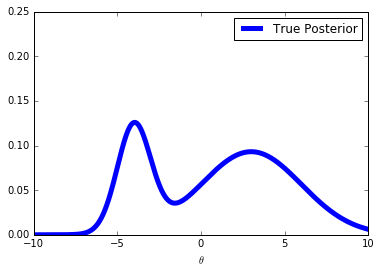

In [4]:
true_posterior_params = {
    'mu': [-4,3],
    'sigma': [1, 3],
    'pi': [.3, .7]
}

plt.figure()

theta_grid = np.linspace(-10, 10, 1000)

probs_true = [np.exp(logGaussMixPDF(z, true_posterior_params)) for z in theta_grid]
plt.plot(theta_grid, probs_true, 'b-', linewidth=5, label="True Posterior")

plt.xlabel(r"$\theta$")
plt.xlim([-10,10])
plt.ylim([0,.25])
plt.legend()

plt.show()

## 2.  Variational Inference via ELBO

Now let's fit a Gaussian approximation--$q(\boldsymbol{\theta};\boldsymbol{\phi}) \ = \ \text{N}(\boldsymbol{\mu}_{\boldsymbol{\phi}}, \boldsymbol{\sigma}_{\boldsymbol{\phi}})$--using the [*Evidence Lower Bound* (ELBO)](http://www.umiacs.umd.edu/~xyang35/files/understanding-variational-lower.pdf): $$ \log p(x) = \mathbb{E}_{q(\boldsymbol{\theta})}[ \log p(\mathbf{X}, \boldsymbol{\theta})] + \mathbb{H}_{q}[\boldsymbol{\theta}] + \text{KLD}[q(\boldsymbol{\theta}) || p(\boldsymbol{\theta} | \mathbf{X})] \ge \mathbb{E}_{q(\boldsymbol{\theta})}[ \log p(\mathbf{X}, \boldsymbol{\theta})] + \mathbb{H}_{q}[\boldsymbol{\theta}].$$

We'll perform fully gradient-based optimization.  Differentiating we have... $$ \frac{\partial}{\partial \boldsymbol{\phi}} \mathcal{L}_{\text{ELBO}} =  \frac{\partial}{\partial \boldsymbol{\phi}} \mathbb{E}_{q(\boldsymbol{\theta})}[ \log p(\mathbf{X}, \boldsymbol{\theta})] + \frac{\partial}{\partial \boldsymbol{\phi}} \mathbb{H}_{q}[\boldsymbol{\theta}].$$

Furthermore, so that we don't have to compute the above expectation by hand, we'll use a Monte Carlo (MC) approximation: $$\mathbb{E}_{q(\boldsymbol{\theta})}[ \log p(\mathbf{X}, \boldsymbol{\theta})] \approx \frac{1}{S} \sum_{s} \log p(\mathbf{X}, \hat{\boldsymbol{\theta}}_{s})  $$ where $\hat{\boldsymbol{\theta}}_{s} \sim q(\boldsymbol{\theta})$.  The resulting gradient is then $$ \frac{\partial}{\partial \boldsymbol{\phi}} \frac{1}{S} \sum_{s} \log p(\mathbf{X}, \hat{\boldsymbol{\theta}}_{s}) = \frac{1}{S} \sum_{s} \frac{\partial}{\partial \hat{\boldsymbol{\theta}}_{s}} \log p(\mathbf{X}, \hat{\boldsymbol{\theta}}_{s}) \frac{\partial \hat{\boldsymbol{\theta}}_{s}}{\partial \boldsymbol{\phi}}.$$  More importantly, we'll also use MC techniques when the expectations don't have analytical solutions (like in the case of Bayesian neural networks).

The first step will be to get the necessary gradient terms via Autograd...

In [5]:
# Entropy of Gaussian
def gaussEntropy(log_sigma):
    return .5 * (np.log(2*np.pi*np.e) + 2.*log_sigma)

# Function for sampling from Gaussian location-scale form
def sample_from_Gauss(mu, log_sigma):
    e = np.random.normal()
    return mu + np.exp(log_sigma) * e, e


### GET DERIVATIVES ###

# d log p(X, \theta) / d \theta
logModel = logGaussMixPDF
dLogModel_dTheta = grad(logModel)

# d theta / d log_sigma
### we'll implement this ourselves

# d entropy / d log_sigma
dEntropy_dLogSigma = grad(gaussEntropy)

Now lets initialize the variational parameters and optimize the ELBO...

In [22]:
### INIT VARIATIONAL PARAMS 
phi = {'mu':-5., 'log_sigma':0.}


### ELBO OPTIMIZATION
maxEpochs = 750
learning_rate = .1
adam_values = {'mu':{'mean': 0., 'var': 0., 't': 0}, 'log_sigma':{'mean': 0., 'var': 0., 't': 0}}
n_samples = 10

for epochIdx in range(maxEpochs):
    
    elbo_grad_mu, elbo_grad_log_sigma = 0., 0.
    for s in range(n_samples):
        
        theta_hat, rand_seed = sample_from_Gauss(phi['mu'], phi['log_sigma'])
        dModel_dTheta = dLogModel_dTheta(theta_hat, true_posterior_params)
        
        elbo_grad_mu += 1./n_samples * dModel_dTheta * 1.
        elbo_grad_log_sigma += 1./n_samples * dModel_dTheta * rand_seed * np.exp(phi['log_sigma'])
        
    elbo_grad_log_sigma += dEntropy_dLogSigma(phi['log_sigma'])
        
    phi['mu'] += get_AdaM_update(learning_rate, elbo_grad_mu, adam_values['mu'])  
    phi['log_sigma'] += get_AdaM_update(learning_rate, elbo_grad_log_sigma, adam_values['log_sigma']) 
        
print phi

{'mu': 2.2863782471565059, 'log_sigma': 1.2724025628035105}


Let's visualize the results...

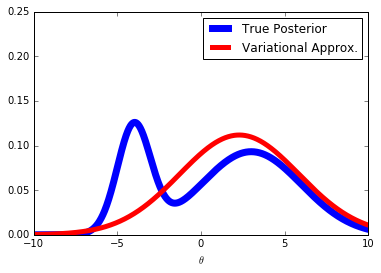

In [23]:
probs_elbo_approx = [gaussPdf(z, {'mu':phi['mu'], 'sigma':np.exp(phi['log_sigma'])}) for z in theta_grid] 
    
plt.figure()

plt.plot(theta_grid, probs_true, 'b-', linewidth=7, label="True Posterior")
plt.plot(theta_grid, probs_elbo_approx, '-r', linewidth=5, label="Variational Approx.")

plt.xlabel(r"$\theta$")
plt.xlim([-10,10])
plt.ylim([0,.25])
plt.legend()

plt.show()

## 3.  Variational Inference via PPVI



In [24]:
### INIT VARIATIONAL PARAMS 
phi = {'mu':-5., 'log_sigma':0.}


### ELBO OPTIMIZATION
maxEpochs = 750
learning_rate = .1
adam_values = {'mu':{'mean': 0., 'var': 0., 't': 0}, 'log_sigma':{'mean': 0., 'var': 0., 't': 0}}
n_samples = 10

for epochIdx in range(maxEpochs):
    
    elbo_val, elbo_grad_mu, elbo_grad_log_sigma = 0., 0., 0.
    for s in range(n_samples):
        
        theta_hat, rand_seed = sample_from_Gauss(phi['mu'], phi['log_sigma'])
        dModel_dTheta = dLogModel_dTheta(theta_hat, true_posterior_params)
        elbo_val += 1./n_samples * logModel(theta_hat, true_posterior_params)
        
        elbo_grad_mu += 1./n_samples * dModel_dTheta * 1.
        elbo_grad_log_sigma += 1./n_samples * dModel_dTheta * rand_seed * np.exp(phi['log_sigma'])
        
    elbo_grad_log_sigma += dEntropy_dLogSigma(phi['log_sigma'])
    elbo_val += gaussEntropy(phi['log_sigma'])
    
    ppvi_grad_mu = elbo_grad_mu + elbo_val * elbo_grad_mu + .5 * elbo_val**2 * elbo_grad_mu
    ppvi_grad_log_sigma = elbo_grad_log_sigma + elbo_val * elbo_grad_log_sigma + .5 * elbo_val**2 * elbo_grad_log_sigma
        
    phi['mu'] += get_AdaM_update(learning_rate, ppvi_grad_mu, adam_values['mu'])  
    phi['log_sigma'] += get_AdaM_update(learning_rate, ppvi_grad_log_sigma, adam_values['log_sigma']) 
        
print phi

{'mu': 1.6761736919381656, 'log_sigma': 1.4576919467696909}


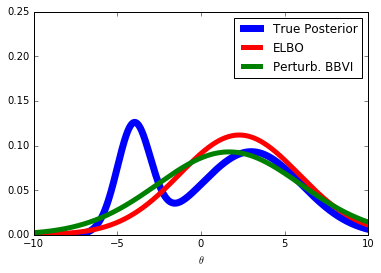

In [25]:
probs_pbbvi_approx = [gaussPdf(z, {'mu':phi['mu'], 'sigma':np.exp(phi['log_sigma'])}) for z in theta_grid] 
    
plt.figure()

plt.plot(theta_grid, probs_true, 'b-', linewidth=7, label="True Posterior")
plt.plot(theta_grid, probs_elbo_approx, '-r', linewidth=5, label="ELBO")
plt.plot(theta_grid, probs_pbbvi_approx, '-g', linewidth=5, label="Perturb. BBVI")

plt.xlabel(r"$\theta$")
plt.xlim([-10,10])
plt.ylim([0,.25])
plt.legend()

plt.show()